<a href="https://colab.research.google.com/github/vanivaranya/Toxic-Comment-Classification/blob/main/Toxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import numpy as np

#misc
import gc
import time
import warnings

#stats
from imageio import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

### Importing the dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv')
subm = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/sample_submission - sample_submission.csv')

### Splitting it into train and test in 80:20 ratio

In [ ]:
train = dataset.iloc[0:int(dataset.shape[0]*0.8), :]
test = dataset.iloc[int(dataset.shape[0]*0.8):, :]

In [ ]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
127656,aac649d868cbe885,March 2007 (UTC)\nIs Image:Marist high school ...,0,0,0,0,0,0
127657,aac68e69d96d625a,Notice to all\n\nI changed my username in acco...,0,0,0,0,0,0
127658,aac73bf42ef22ff9,"""\nWP articles are not genealogical entries or...",0,0,0,0,0,0
127659,aac894fa28474fdf,REDIRECT Talk:John Rogers (footballer),0,0,0,0,0,0
127660,aaca8c54dc5222af,NFL Draft\nAre you batch copy-and-pasting the ...,0,0,0,0,0,0


In [ ]:
train.shape

(127656, 8)

In [ ]:
test.shape

(31915, 8)

In [ ]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Identifying Clean Comments

In [ ]:
#counting number of tags for each row
x=train.iloc[:,2:].sum()

#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)

print("Total comments = ", len(train))
print("Total clean comments = ", train['clean'].sum())
print("Total tags =", x.sum())

Total comments =  127656
Total clean comments =  114656
Total tags = 28102


### Checking for Null Values

In [ ]:
print("Check for missing values in Train dataset")
print(train.isnull().sum())

print("Check for missing values in Test dataset")
print(test.isnull().sum())

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


### Frequency of each tag

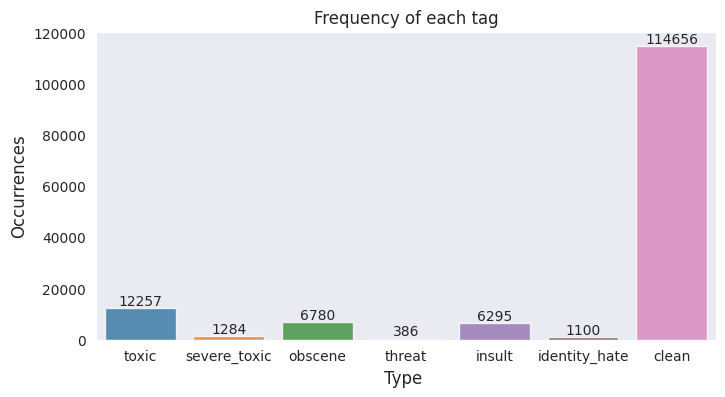

In [ ]:
X=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x=X.index, y=X.values, alpha=0.8)
plt.title("Frequency of each tag")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = X.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

*   The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems

*   There are ~127k comments in the training dataset and there are ~140k tags and ~114k clean comments. This is only possible when multiple tags are associated with each comment for example, comment can be classified as both toxic and obscene.



### Number of Tags per Comment

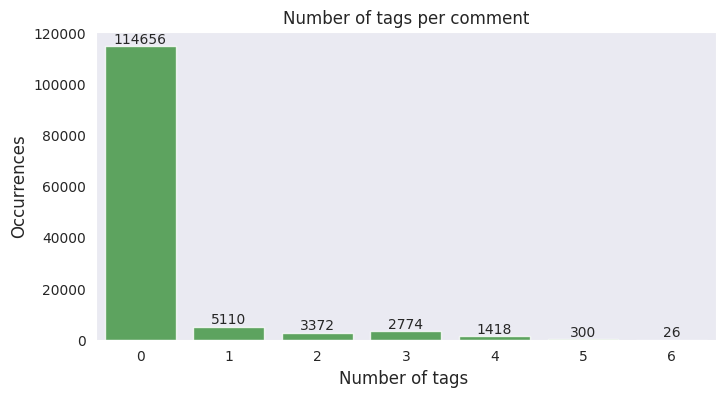

In [ ]:
X=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=X.index, y=X.values, alpha=0.8,color=color[2])
plt.title("Number of tags per comment")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Number of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = X.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Only ~10% of the total comments have some sort of toxicity in them. There are certain comments(26) that are marked with all the tags.



```
# This is formatted as code
```

### Confusion Matrix/Crosstab

In [ ]:
def highlight_min(data, color='blue'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a look at toxic with other tags
temp_df=train.iloc[:,2:-1]
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.

*   A Severe toxic comment is always toxic
*   Other classes seem to be a subset of toxic barring a few exceptions

### Cramer's V Statistic

In [ ]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             115399     0
1              10973  1284
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30914540389470313


### Word Cloud

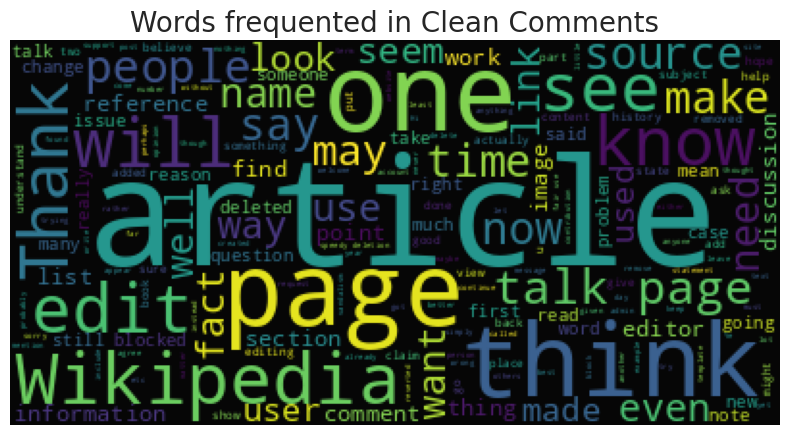

In [ ]:
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

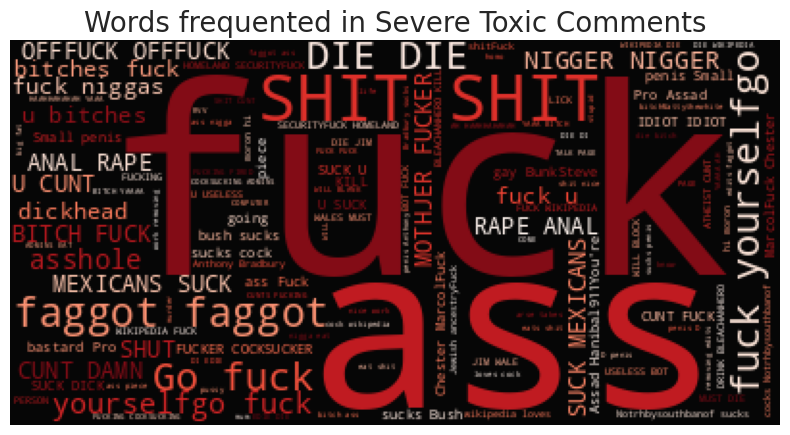

In [ ]:
#Severely toxic comments
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
plt.show()

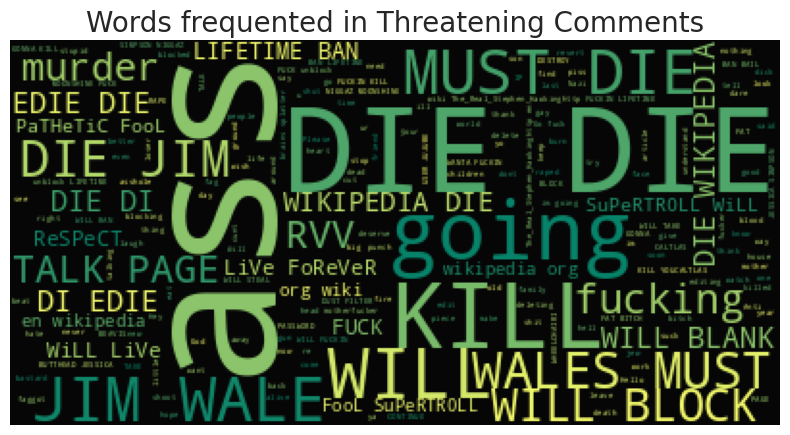

In [ ]:
#Threat comments
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)
plt.show()

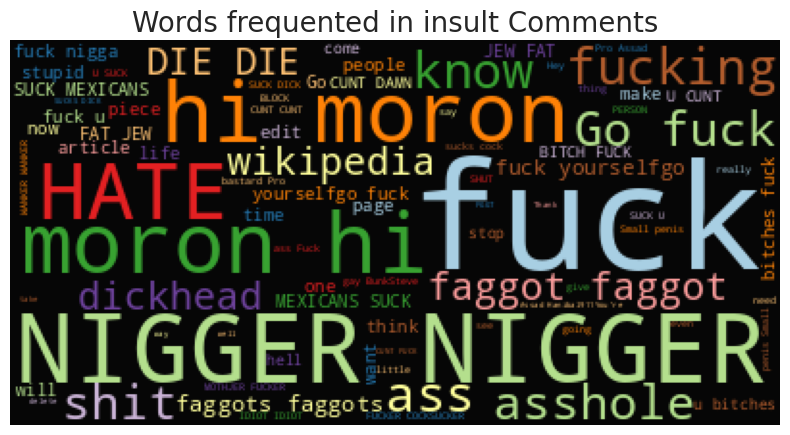

In [ ]:
#insult
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
plt.show()

### Indirect Features

In [ ]:
# Merge train and test data
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [ ]:
#Sentence count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))

#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
df.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769


### Derived Features

In [ ]:
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']

#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [ ]:
df.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538


In [ ]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

### Spamming

In [ ]:
#spammers - comments with less than 30% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

In [ ]:
# Number of spam comments
spammers.shape[0]

371

In [ ]:
# Number of clean spam comments
spammers[spammers['clean']==1].shape[0]

100

### Percentage of unique words of total words in comment

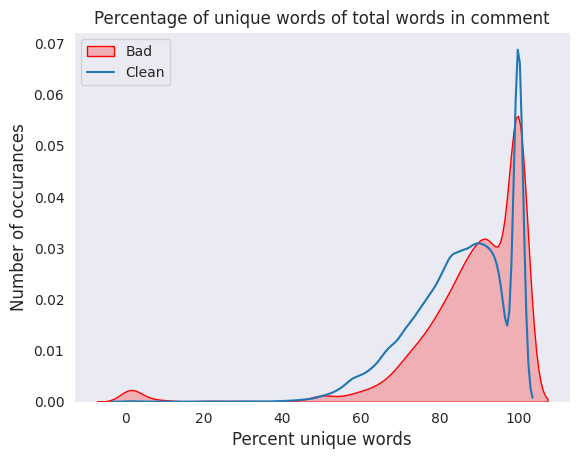

In [ ]:
plt.title("Percentage of unique words of total words in comment")
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)
plt.show()





*   There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.
*   Even though the number of clean comments dominates the dataset(~90%), there are only 100 clean comments that are spam, which makes it a powerful indicator of a toxic comment.



### Count of comments with low unique words

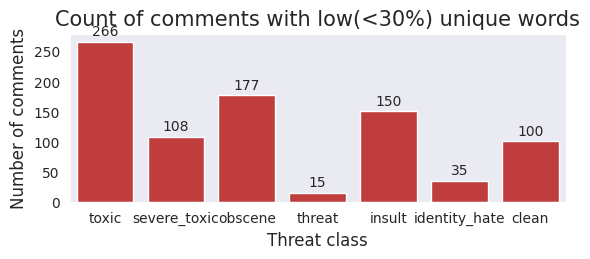

In [ ]:
# Count of comments with low unique words
x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('Number of comments', fontsize=12)
plt.show()

### Spammers are more toxic

In [ ]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

### Corpus Cleaning

In [ ]:
corpus=merge.comment_text

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [ ]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)

    #Split the sentences into words
    words=tokenizer.tokenize(comment)

    # (')aphostophe  replacement (ie)   you're --> you are
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]

    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [ ]:
clean_corpus=corpus.apply(lambda x :clean(x))

### Unigrams -- TF-IDF

In [ ]:
#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)


#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000,
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names_out())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''

    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
#get top n for unigrams
tfidf_top_n_per_class = top_feats_by_class(train_unigrams,features)

Text(0, 0.5, 'TF-IDF score')

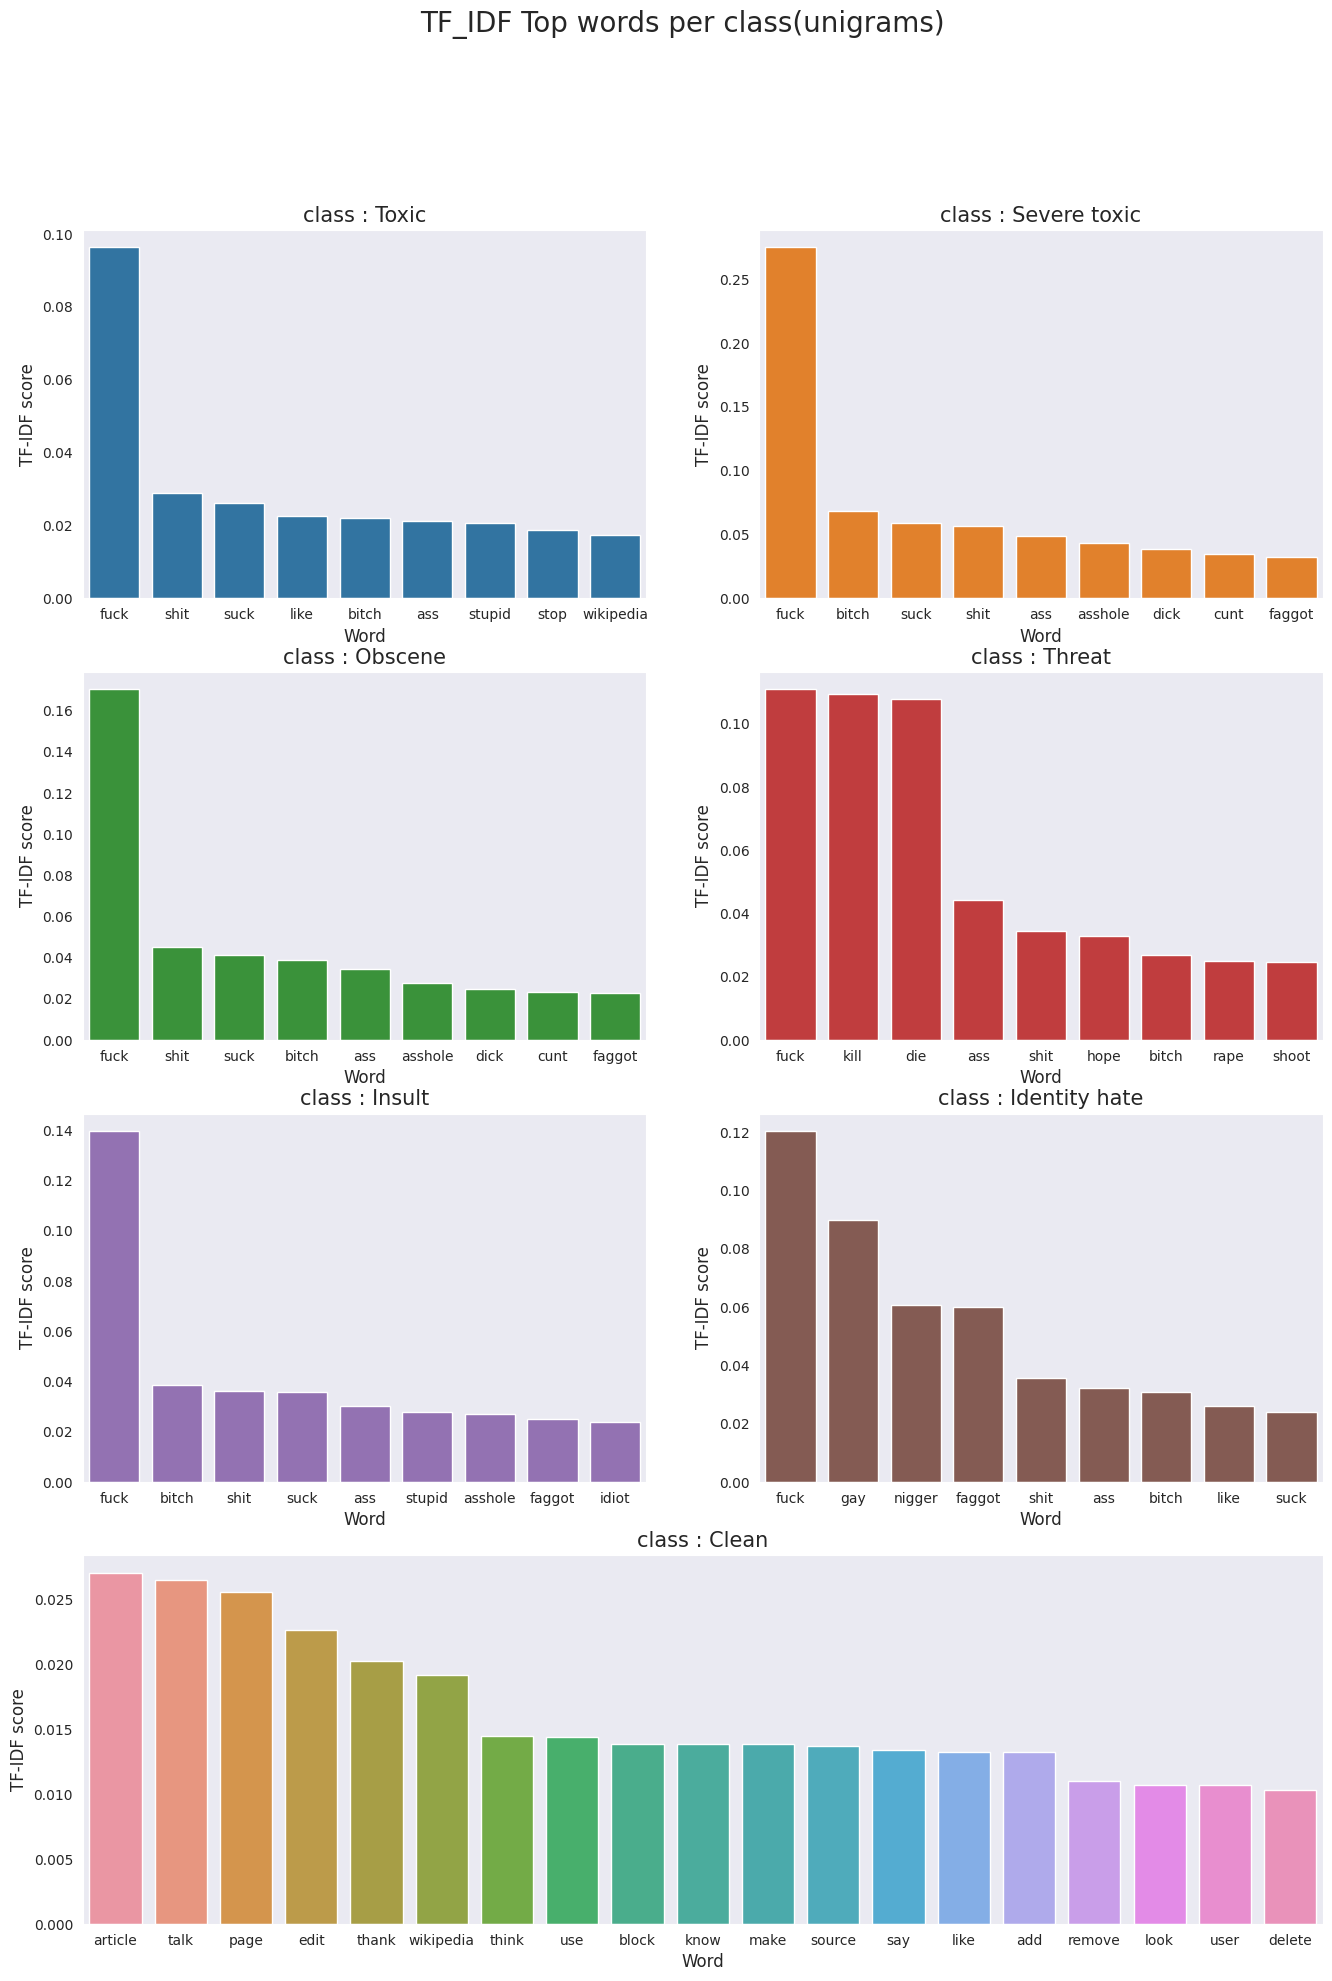

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(x=tfidf_top_n_per_class[0].feature.iloc[0:9],y=tfidf_top_n_per_class[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(x=tfidf_top_n_per_class[1].feature.iloc[0:9],y=tfidf_top_n_per_class[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(x=tfidf_top_n_per_class[2].feature.iloc[0:9],y=tfidf_top_n_per_class[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(x=tfidf_top_n_per_class[3].feature.iloc[0:9],y=tfidf_top_n_per_class[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(x=tfidf_top_n_per_class[4].feature.iloc[0:9],y=tfidf_top_n_per_class[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(x=tfidf_top_n_per_class[5].feature.iloc[0:9],y=tfidf_top_n_per_class[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(x=tfidf_top_n_per_class[6].feature.iloc[0:19],y=tfidf_top_n_per_class[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


### Bigrams -- TF-IDF

In [ ]:
#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
tfv = TfidfVectorizer(min_df=150,  max_features=30000,
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names_out())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

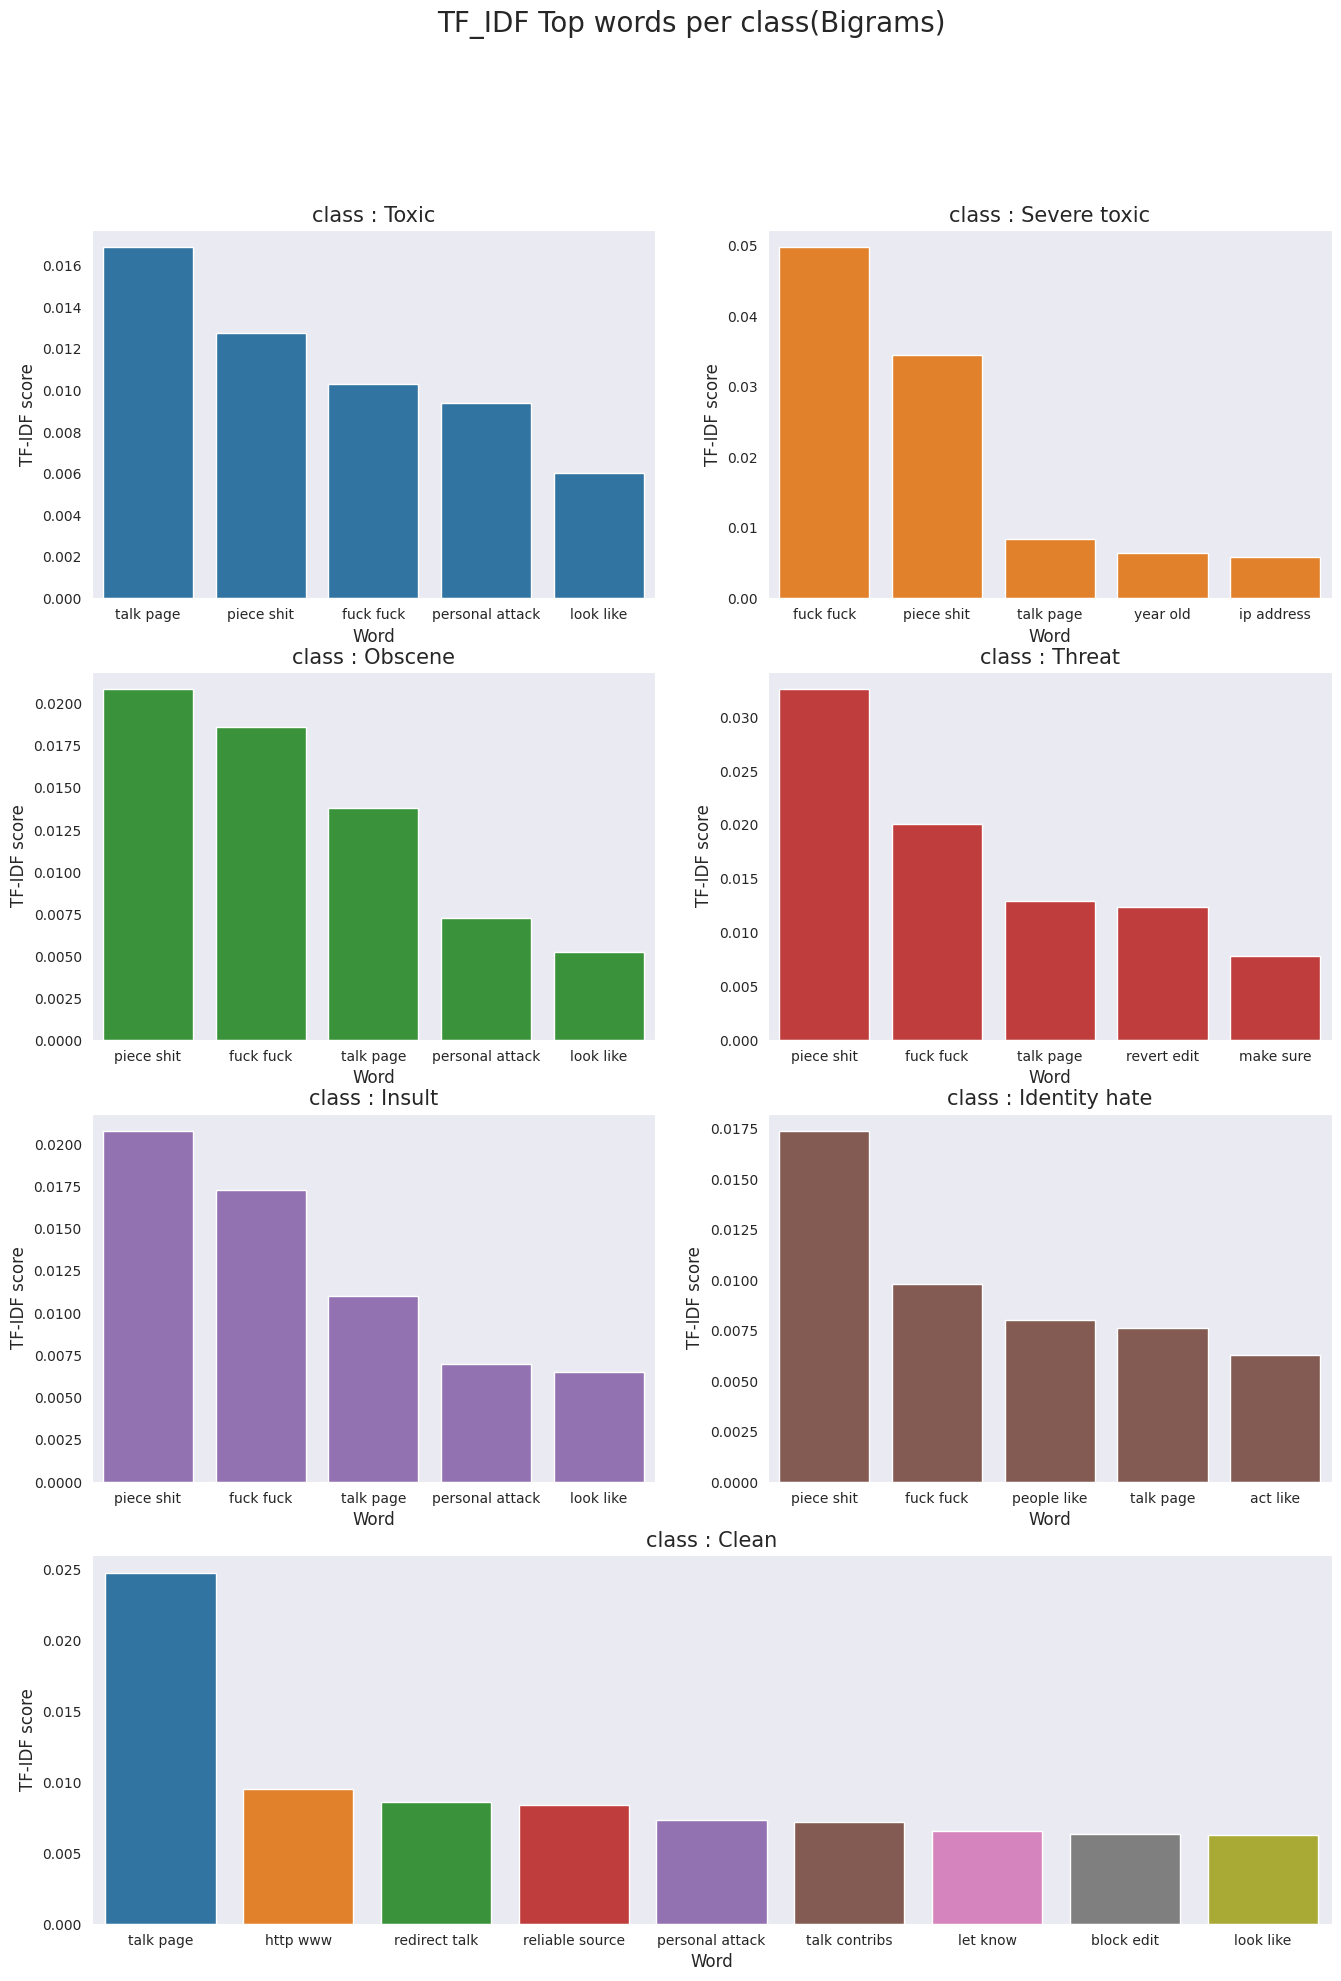

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(x=tfidf_top_n_per_lass[0].feature.iloc[0:5],y=tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(x=tfidf_top_n_per_lass[1].feature.iloc[0:5],y=tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(x=tfidf_top_n_per_lass[2].feature.iloc[0:5],y=tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(x=tfidf_top_n_per_lass[3].feature.iloc[0:5],y=tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(x=tfidf_top_n_per_lass[4].feature.iloc[0:5],y=tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(x=tfidf_top_n_per_lass[5].feature.iloc[0:5],y=tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(x=tfidf_top_n_per_lass[6].feature.iloc[0:9],y=tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

### Naive Bayes-Logistic Regression Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [ ]:
y_true = test.loc[:, ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
y_true_array = y_true.to_numpy()

In [ ]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [ ]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [ ]:
x = trn_term_doc
test_x = test_term_doc

In [ ]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=False)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [ ]:
submid1 = pd.DataFrame({'id': subm["id"]})
submission1 = pd.concat([submid1, pd.DataFrame(preds, columns = label_cols)], axis=1)

In [ ]:
submission1_arr = submission1.loc[:, label_cols].to_numpy()

In [ ]:
# Combine probabilities into a single column
combined_probabilities = submission1_arr.flatten()

# Transform y_true into a corresponding binary array
combined_binary_labels = np.zeros_like(combined_probabilities)
for instance_index in range(submission1_arr.shape[0]):
    # Get the labels for the current instance
    instance_labels = y_true_array[instance_index]  # Assuming y_true is a 2D array

    # Find the indices of the labels that are set to 1
    label_indices = np.where(instance_labels == 1)[0]

    # Set the corresponding indices in combined_binary_labels to 1
    combined_binary_labels[instance_index * submission1_arr.shape[1] + label_indices] = 1

# Calculate ROC curve and AUC for the combined probabilities
fpr, tpr, thresholds = roc_curve(combined_binary_labels, combined_probabilities)
roc_auc = roc_auc_score(combined_binary_labels, combined_probabilities)

# Find the threshold that maximizes accuracy
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

# Convert probability predictions to binary predictions using the best threshold
y_pred_labels = (combined_probabilities > best_threshold).astype(int)

# Calculate accuracy using the best threshold
accuracy = accuracy_score(combined_binary_labels, y_pred_labels)

print(f"Best Threshold: {best_threshold:.8f}")
print(f"Best Accuracy: {accuracy:.8f}")

Best Threshold: 0.01600285
Best Accuracy: 0.94219541


### LSTM + GloVe embeddings

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
import gensim

In [ ]:
!wget nlp.stanford.edu/data/glove.6B.zip

--2023-08-20 07:05:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-20 07:05:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-20 07:05:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
EMBEDDING_FILE=f'glove.6B.50d.txt'

In [ ]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [ ]:
list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_t, y, batch_size=32, epochs=4, validation_split=0.1);

Epoch 1/4
3591/3591 [==============================] - 1074s 299ms/step - loss: 0.0338 - accuracy: 0.9310 - val_loss: 0.0505 - val_accuracy: 0.9763
Epoch 2/4
3591/3591 [==============================] - 1078s 300ms/step - loss: 0.0310 - accuracy: 0.8592 - val_loss: 0.0542 - val_accuracy: 0.9539
Epoch 3/4
3591/3591 [==============================] - 1074s 299ms/step - loss: 0.0284 - accuracy: 0.8281 - val_loss: 0.0577 - val_accuracy: 0.7866
Epoch 4/4
3591/3591 [==============================] - 1080s 301ms/step - loss: 0.0260 - accuracy: 0.6837 - val_loss: 0.0620 - val_accuracy: 0.8802


In [ ]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)

submid2 = pd.DataFrame({'id': subm["id"]})
submission2 = pd.concat([submid2, pd.DataFrame(y_test, columns = label_cols)], axis=1)

32/32 [==============================] - 15s 468ms/step


In [ ]:
submission2_arr = submission2.loc[:, label_cols].to_numpy()

In [ ]:
# Combine probabilities into a single column
combined_probabilities = submission2_arr.flatten()

# Transform y_true into a corresponding binary array
combined_binary_labels = np.zeros_like(combined_probabilities)
for instance_index in range(submission2_arr.shape[0]):
    # Get the labels for the current instance
    instance_labels = y_true_array[instance_index]  # Assuming y_true is a 2D array

    # Find the indices of the labels that are set to 1
    label_indices = np.where(instance_labels == 1)[0]

    # Set the corresponding indices in combined_binary_labels to 1
    combined_binary_labels[instance_index * submission2_arr.shape[1] + label_indices] = 1

# Calculate ROC curve and AUC for the combined probabilities
fpr, tpr, thresholds = roc_curve(combined_binary_labels, combined_probabilities)
roc_auc = roc_auc_score(combined_binary_labels, combined_probabilities)

# Find the threshold that maximizes accuracy
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

# Convert probability predictions to binary predictions using the best threshold
y_pred_labels = (combined_probabilities > best_threshold).astype(int)

# Calculate accuracy using the best threshold
accuracy = accuracy_score(combined_binary_labels, y_pred_labels)

print(f"Best Threshold: {best_threshold:.8f}")
print(f"Best Accuracy: {accuracy:.8f}")

Best Threshold: 0.00257881
Best Accuracy: 0.93502011


### Resultant of LSTM and Naive Bayes-Logistic Regression Model

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
p_res = submission2.copy()
p_res[label_cols] = (submission1[label_cols] + submission2[label_cols]) / 2

In [ ]:
arr = p_res.loc[:, label_cols].to_numpy()

In [ ]:
# Combine probabilities into a single column
combined_probabilities = arr.flatten()

# Transform y_true into a corresponding binary array
combined_binary_labels = np.zeros_like(combined_probabilities)
for instance_index in range(arr.shape[0]):
    # Get the labels for the current instance
    instance_labels = y_true_array[instance_index]  # Assuming y_true is a 2D array

    # Find the indices of the labels that are set to 1
    label_indices = np.where(instance_labels == 1)[0]

    # Set the corresponding indices in combined_binary_labels to 1
    combined_binary_labels[instance_index * arr.shape[1] + label_indices] = 1

# Calculate ROC curve and AUC for the combined probabilities
fpr, tpr, thresholds = roc_curve(combined_binary_labels, combined_probabilities)
roc_auc = roc_auc_score(combined_binary_labels, combined_probabilities)

# Find the threshold that maximizes accuracy
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

# Convert probability predictions to binary predictions using the best threshold
y_pred_labels = (combined_probabilities > best_threshold).astype(int)

# Calculate accuracy using the best threshold
accuracy = accuracy_score(combined_binary_labels, y_pred_labels)

print(f"Best Threshold: {best_threshold:.8f}")
print(f"Best Accuracy: {accuracy:.8f}")

Best Threshold: 0.01263199
Best Accuracy: 0.94344874
